# Chapter 4: Bayesian Statistics (Working in progress proof of concept)

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../")

# Importing gempy
import gempy as gp

# Embedding matplotlib figures into the notebooks
%matplotlib inline

# Aux imports
import numpy as np

import matplotlib.pyplot as plt

In [48]:
geo_data = gp.create_data([696000-10000,747000 + 20600,6863000 - 20600,6950000 + 20600,-20000, 600],[16, 16, 16],
                         path_f = os.pardir+"/input_data/a_Foliations.csv",
                         path_i = os.pardir+"/input_data/a_Points.csv")

# Assigning series to formations as well as their order (timewise)
gp.set_data_series(geo_data, {"EarlyGranite_Series": 'EarlyGranite', 
                              "BIF_Series":('SimpleMafic2', 'SimpleBIF'),
                              "SimpleMafic_Series":'SimpleMafic1'}, 
                      order_series = ["EarlyGranite_Series",
                                      "BIF_Series",
                                      "SimpleMafic_Series"], verbose=1)
geo_data.geo_data_type = 'none'


In [49]:
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = 0
geo_data.interfaces['Z_std'] = 50

geo_data.foliations['X_std'] = None
geo_data.foliations['Y_std'] = 0
geo_data.foliations['Z_std'] = 0

In [50]:
geo_data.foliations['dip_std'] = 10
geo_data.foliations['azimuth_std'] = 10
geo_data.foliations.head()

,X,Y,Z,azimuth,dip,polarity,formation,series,order_series,G_x,G_y,G_z,X_std,Y_std,Z_std,dip_std,azimuth_std
0,735082.0630,6879102.25,480.551436,276.153239,80.0,1,EarlyGranite,EarlyGranite_Series,1,-0.979134,0.105560,0.173648,None,0,0,10,10
1,735326.7815,6875283.75,452.966456,114.812185,80.0,1,EarlyGranite,EarlyGranite_Series,1,0.893898,-0.413270,0.173648,None,0,0,10,10
2,738704.4065,6877046.00,458.148740,170.056246,80.0,1,EarlyGranite,EarlyGranite_Series,1,0.170058,-0.970014,0.173648,None,0,0,10,10
3,743403.6875,6877878.25,454.749952,169.802194,80.0,1,EarlyGranite,EarlyGranite_Series,1,0.174357,-0.969250,0.173648,None,0,0,10,10
4,734151.9690,6874304.75,448.179887,206.518042,80.0,1,EarlyGranite,EarlyGranite_Series,1,-0.439697,-0.881200,0.173648,None,0,0,10,10


In [51]:
interp_data = gp.InterpolatorInput(geo_data, compile_theano=True, u_grade=[3,3,3])

I am here
I am in the setting
float32
I am here
[2, 2]


In [52]:
interp_data.data.interfaces.head()

,X,Y,Z,formation,series,order_series,X_std,Y_std,Z_std,formation number
0,0.251624,0.2501,0.545482,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.000515,1
1,0.280857,0.288407,0.545625,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.000515,1
2,0.49254,0.399287,0.545915,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.000515,1
3,0.584269,0.375096,0.545618,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.000515,1
4,0.582253,0.403318,0.545733,EarlyGranite,EarlyGranite_Series,1,NaN,0.0,0.000515,1


In [53]:

sol = gp.compute_model(interp_data)

[3, 3, 3]


/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.1069411932094226e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


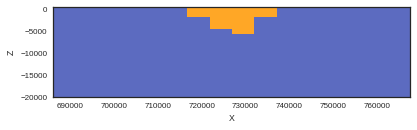

In [64]:
gp.plot_section(geo_data, sol[-1,0,:], 7)

In [54]:
def precompute_grav(interp_data):
    """
    model_res: number of voxels
    interp_data: interp_data object with the specific resolution
    """
    
    import sys
    import gempy as gp
    sys.path.append("../gempy")
    import GeoPhysics
    import theano.tensor as T
    import theano
    from importlib import reload
    reload(GeoPhysics)

    #inter_data = gp.InterpolatorInput(geo_data, compile_theano=False)
    gpp = GeoPhysics.GeoPhysicsPreprocessing(interp_data,580,  [7.050000e+05,747000,6863000,6925000,-20000, 200], 
                                  res_grav = [5, 5],
                                  n_cells = 10, mode='range')
                                  #res_grav = [125, 85],
                                  #n_cells =1000)
    print(gpp)

    
    # Compile Theano function
    x_1 = T.matrix()
    x_2 = T.matrix()

    sqd = T.sqrt(T.maximum(
        (x_1 ** 2).sum(1).reshape((x_1.shape[0], 1)) +
        (x_2 ** 2).sum(1).reshape((1, x_2.shape[0])) -
        2 * x_1.dot(x_2.T), 0
    ))
    eu = theano.function([x_1, x_2], sqd, allow_input_downcast=True)
        
    # Init
    i_0 = 0
    model_res = interp_data.resolution[0] * interp_data.resolution[1] * interp_data.resolution[2]
    b_all = np.zeros((0,model_res), dtype=bool)
    
    # 25 is the size of the chunk
    for i_1 in np.arange(25, gpp.airborne_plane.shape[0]+1, 25, dtype=int):#np.linspace(gpp.airborne_plane.shape[0]/25, gpp.airborne_plane.shape[0], 26, dtype=int):
        airborne_plane_s = gpp.airborne_plane[i_0:i_1]


        d = eu(interp_data.data.grid.grid.astype('float'), airborne_plane_s)
        ab_g = interp_data.data.grid.grid[np.argmin(d, axis=0)]
        ab_g[:,2] = ab_g[:,2] + 0.01

        d2 = eu(ab_g, interp_data.data.grid.grid.astype('float'))
        
        # Max range to select voxels
        range_ = (interp_data.data.grid.grid[:, 2].max() - interp_data.data.grid.grid[:, 2].min()) *0.9
        
        # Boolean of the selection
        b = d2<range_
        
        # Beoolean for all measurements
        b_all = np.vstack((b_all, b))
        
        # Selection of the x y z coordenates for each measurement and computed distance in those coordinates
        s_gr_x = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, :25].T[b].reshape(25,-1) - ab_g[:,0].reshape(25,-1)).astype('float')
        s_gr_y = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, 25:50].T[b].reshape(25,-1) - ab_g[:,1].reshape(25,-1)).astype('float')
        s_gr_z = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, -25:].T[b].reshape(25,-1) - ab_g[:,2].reshape(25,-1)).astype('float')
        
        # getting the coordinates of the corners of the voxel
        x_cor = np.stack((s_gr_x - gpp.vox_size[0], s_gr_x + gpp.vox_size[0]), axis=2)
        y_cor = np.stack((s_gr_y - gpp.vox_size[1], s_gr_y + gpp.vox_size[1]), axis=2)
        z_cor = np.stack((s_gr_z - gpp.vox_size[2], s_gr_z + gpp.vox_size[2]), axis=2)

        # ...and prepare them for a vectorial op
        x_matrix = np.repeat(x_cor, 4, axis=2)
        y_matrix = np.tile(np.repeat(y_cor, 2, axis=2), (1, 1, 2))
        z_matrix = np.tile(z_cor, (1, 1, 4))
        
        # Distances to each corner of the voxel
        s_r = np.sqrt(x_matrix**2 + y_matrix**2 + z_matrix**2)


        # Computing z component
        from scipy.constants import G
        mu = np.array([1, -1, -1, 1, -1, 1, 1, -1])

        tz = np.sum(- G * mu * (
                x_matrix * np.log(y_matrix + s_r) +
                y_matrix * np.log(x_matrix + s_r) -
                z_matrix * np.arctan(x_matrix * y_matrix /
                                    (z_matrix * s_r))), axis=2)

        # Stacking the precomputation
        if i_0 == 0:
            tz_all = tz

        else:
            tz_all = np.vstack((tz_all, tz))

        i_0 = i_1
    return tz_all, b_all

In [55]:
tz_, b_ = precompute_grav(interp_data)

0.1908919617392378


In [56]:
import pymc

Z_rest = pymc.Normal('Z_unc_rest',  interp_data.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'))

Z_ref = pymc.Normal('Z_unc_ref',  interp_data.interpolator.pandas_ref_layer_points['Z'].as_matrix().astype('float32'),
           1./interp_data.interpolator.pandas_ref_layer_points['Z_std'].as_matrix().astype('float32'))

dip_u = pymc.Normal('dip_unc',  interp_data.data.foliations['dip'].as_matrix().astype('float32'),
           1./interp_data.data.foliations['dip_std'].as_matrix().astype('float32'))

azimuth_u = pymc.Normal('azimuth_unc',  interp_data.data.foliations['azimuth'].as_matrix().astype('float32'),
           1./interp_data.data.foliations['azimuth_std'].as_matrix().astype('float32'))

i = interp_data.get_input_data()

@pymc.deterministic
def grav(value=0, input_ =  i, Z_rest_m = Z_rest, Z_ref_m = Z_ref, dip_m = dip_u, azimuth_m = azimuth_u):

   # print(Z_rest_m)
    
    input_[1] = dip_m.astype('float32')
    input_[2] = azimuth_m.astype('float32')
    input_[4][:, 2] = Z_ref_m
    input_[5][:, 2] = Z_rest_m
    
    sol = interp_data.th_fn(*input_)
    #print("he", sol[0,0,:].sum())
    # return solution
    lith = sol[-1, 0, :]
    lith_s = np.tile(lith, (25,1))[b_].reshape(25,-1)
    grav = lith_s* tz_
    return grav.sum(axis=1)
    
  #  return sol

# @pymc.deterministic
# def grav(value=0, model=gempy_model):
#     lith = model[-1, 0, :]
#     lith_s = np.tile(lith, (25,1))[b_].reshape(25,-1)
#     grav = lith_s* tz_
#     return grav.sum(axis=1)

[3, 3, 3]


In [57]:

np.random.seed(123456)
pymc_model = pymc.Model(input = [Z_ref, Z_rest,  dip_u,  azimuth_u, grav])

MCFS_RUN_16 = pymc.MCMC(pymc_model)#,  db='pickle', dbname='MCMC16.pickle')
MCFS_RUN_16.sample(iter=100)

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.064899966100711e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-------------    35%                  ] 35 of 100 complete in 0.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.571600425469114e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.8928015417004644e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.2049905718831724e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------65%----              ] 65 of 100 complete in 1.0 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.1274941625933934e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.182751922598982e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.1175184978546895e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------93%---------------   ] 93 of 100 complete in 1.5 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.718667139831268e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


 [-----------------100%-----------------] 100 of 100 complete in 1.7 sec

/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.607261772093807e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


In [59]:
MCFS_RUN_16.trace('grav')[:][:, 8] - MCFS_RUN_16.trace('grav')[:][:, 8]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### 8

Plotting grav_0
Plotting grav_1
Plotting grav_2
Plotting grav_3
Plotting grav_4
Plotting grav_5
Plotting grav_6
Plotting grav_7
Plotting grav_8
Plotting grav_9
Plotting grav_10
Plotting grav_11
Plotting grav_12
Plotting grav_13
Plotting grav_14
Plotting grav_15
Plotting grav_16
Plotting grav_17
Plotting grav_18
Plotting grav_19
Plotting grav_20
Plotting grav_21
Plotting grav_22
Plotting grav_23
Plotting grav_24


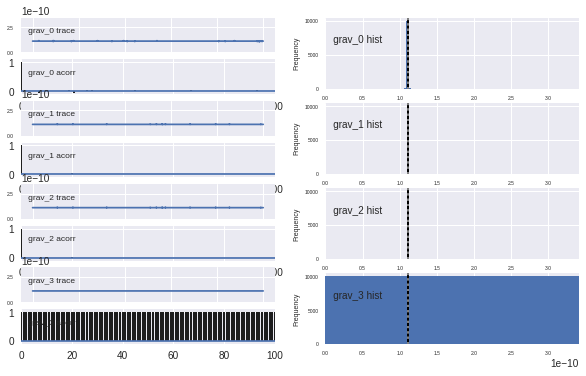

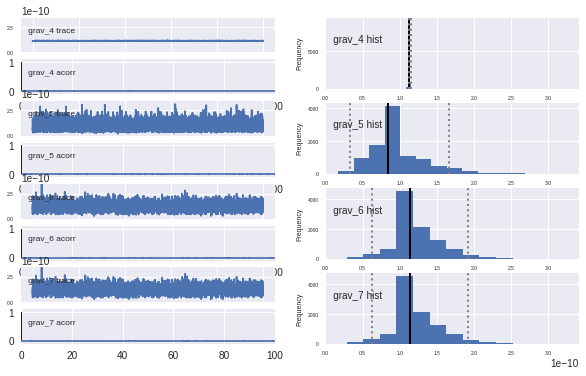

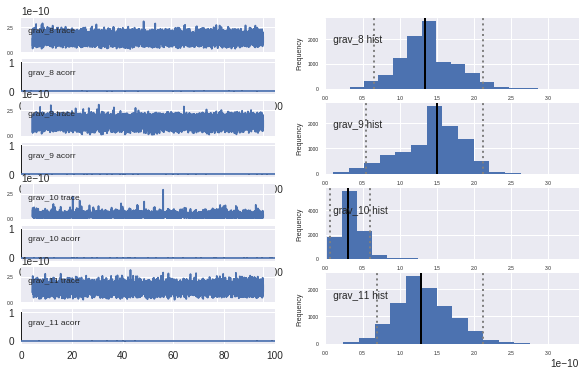

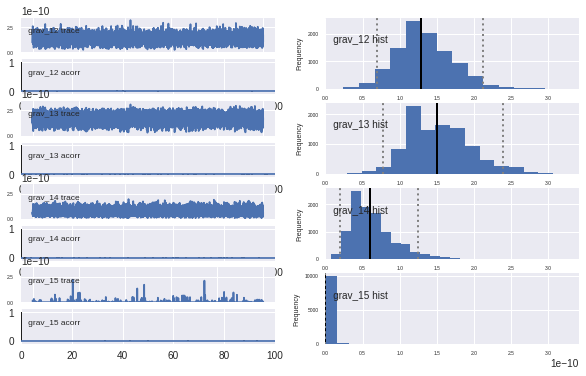

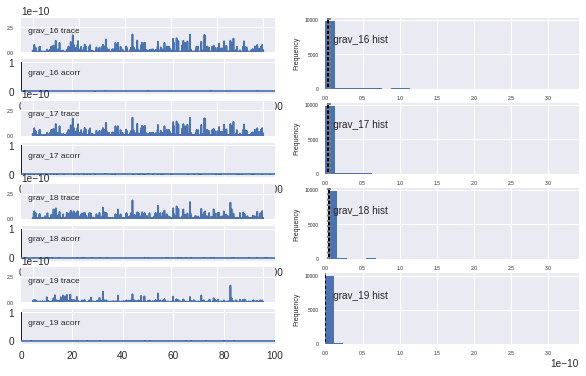

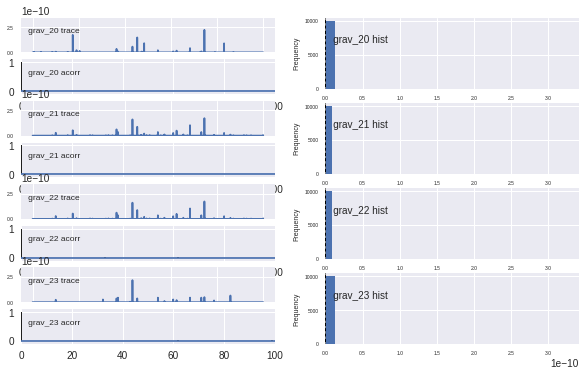

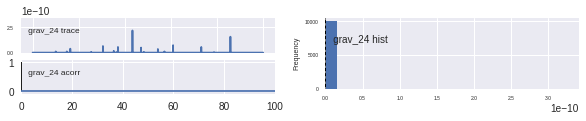

In [14]:
pymc.Matplot.plot(MCFS_RUN_8.trace('grav'))

In [15]:
MCFS_RUN_8.trace('grav').stats()

/home/miguel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


{'95% HPD interval': array([[  1.10569585e-10,   1.10569845e-10,   1.10569845e-10,
           1.10569845e-10,   1.12171418e-10,   3.31095837e-11,
           6.26419005e-11,   6.26419005e-11,   6.48159254e-11,
           5.46451502e-11,   6.13873423e-12,   6.91542367e-11,
           6.91542367e-11,   7.70816107e-11,   2.02048424e-11,
           0.00000000e+00,   3.20366493e-12,   3.20366493e-12,
           3.20366493e-12,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  1.10569585e-10,   1.10569845e-10,   1.10569845e-10,
           1.10569845e-10,   1.15375083e-10,   1.66260573e-10,
           1.91858801e-10,   1.91858801e-10,   2.12891696e-10,
           2.11729590e-10,   6.02640924e-11,   2.12312001e-10,
           2.12312001e-10,   2.39842258e-10,   1.24317727e-10,
           0.00000000e+00,   6.40732986e-12,   6.40732986e-12,
           6.40732986e-12,   0.00000000e+00,   0.00000000e+00,
       

### 16

Plotting grav_0
Plotting grav_1
Plotting grav_2
Plotting grav_3
Plotting grav_4
Plotting grav_5
Plotting grav_6
Plotting grav_7
Plotting grav_8
Plotting grav_9
Plotting grav_10
Plotting grav_11
Plotting grav_12
Plotting grav_13
Plotting grav_14
Plotting grav_15
Plotting grav_16
Plotting grav_17
Plotting grav_18
Plotting grav_19
Plotting grav_20
Plotting grav_21
Plotting grav_22
Plotting grav_23
Plotting grav_24


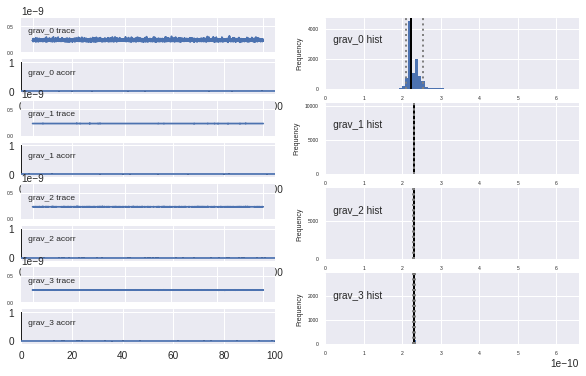

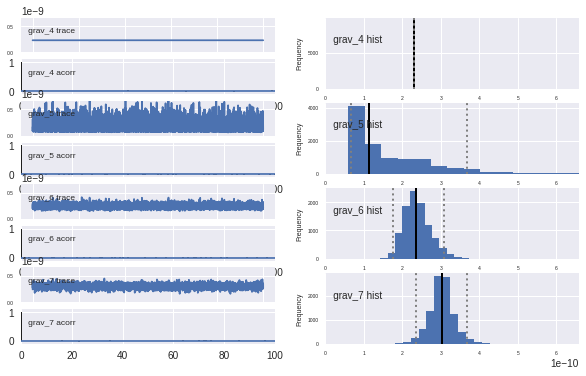

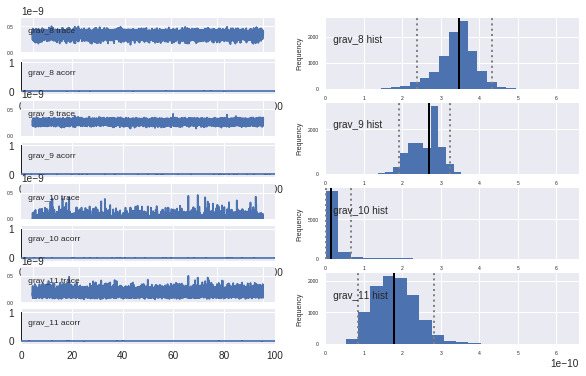

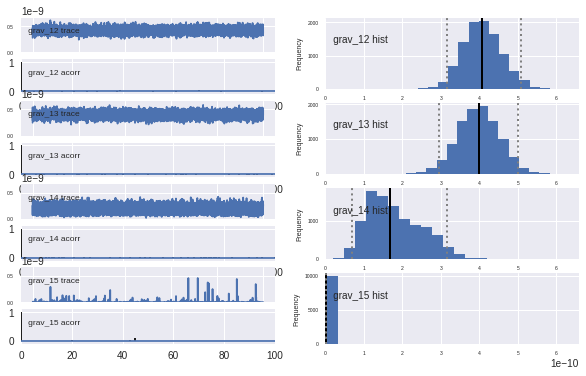

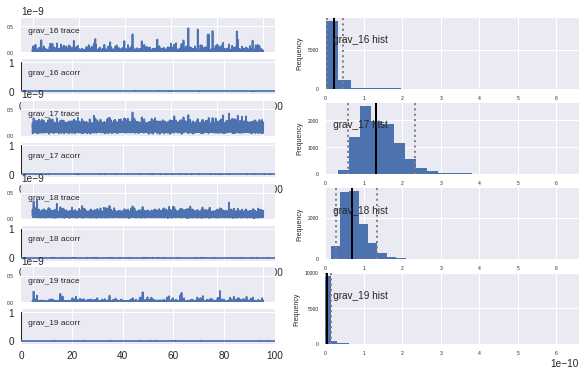

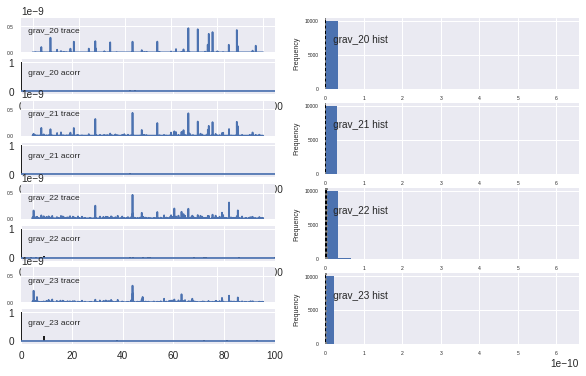

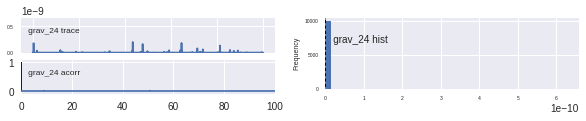

In [24]:
pymc.Matplot.plot(MCFS_RUN_16.trace('grav'))

In [25]:
MCFS_RUN_16.trace('grav').stats()

/home/miguel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


{'95% HPD interval': array([[  2.08261741e-10,   2.29180491e-10,   2.28424031e-10,
           2.28195964e-10,   2.28942868e-10,   6.55591626e-11,
           1.75499614e-10,   2.34649796e-10,   2.38569940e-10,
           1.91397284e-10,   1.22213502e-12,   8.45563834e-11,
           3.16909883e-10,   2.94420915e-10,   6.77742005e-11,
           0.00000000e+00,   3.62761143e-12,   5.93633010e-11,
           2.75171395e-11,   1.51299609e-13,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  2.53748700e-10,   2.29180491e-10,   2.30386053e-10,
           2.33132523e-10,   2.29180491e-10,   3.66883307e-10,
           3.08708455e-10,   3.68880699e-10,   4.31454552e-10,
           3.23452628e-10,   6.61590358e-11,   2.82424678e-10,
           5.09034643e-10,   4.98972272e-10,   3.15359910e-10,
           7.91654714e-13,   4.49444076e-11,   2.32832428e-10,
           1.33458537e-10,   1.52027352e-11,   0.00000000e+00,
       

### 32

Plotting grav_0
Plotting grav_1
Plotting grav_2
Plotting grav_3
Plotting grav_4
Plotting grav_5
Plotting grav_6
Plotting grav_7
Plotting grav_8
Plotting grav_9
Plotting grav_10
Plotting grav_11
Plotting grav_12
Plotting grav_13
Plotting grav_14
Plotting grav_15
Plotting grav_16
Plotting grav_17
Plotting grav_18
Plotting grav_19
Plotting grav_20
Plotting grav_21
Plotting grav_22
Plotting grav_23
Plotting grav_24


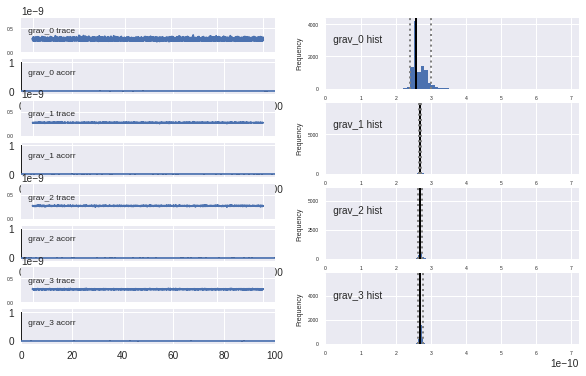

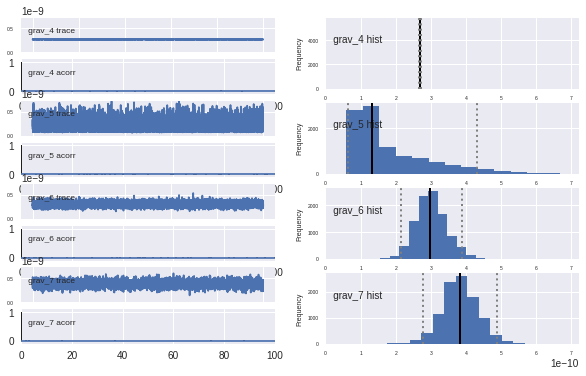

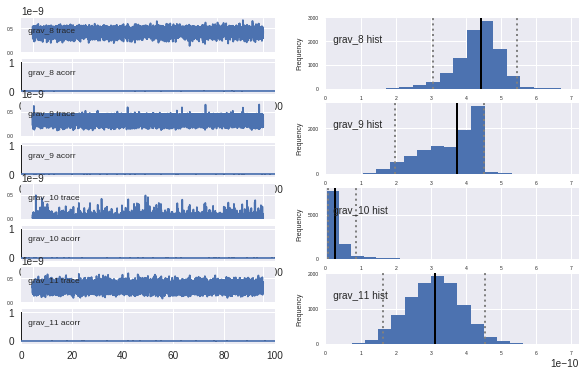

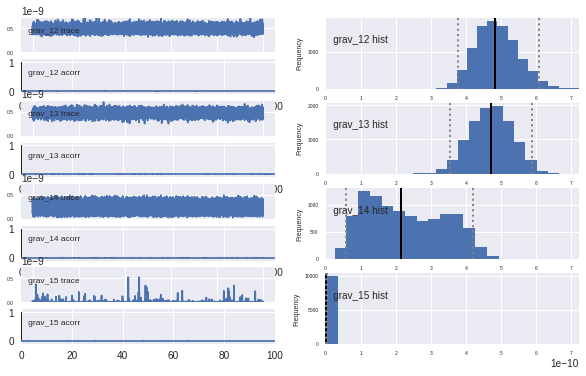

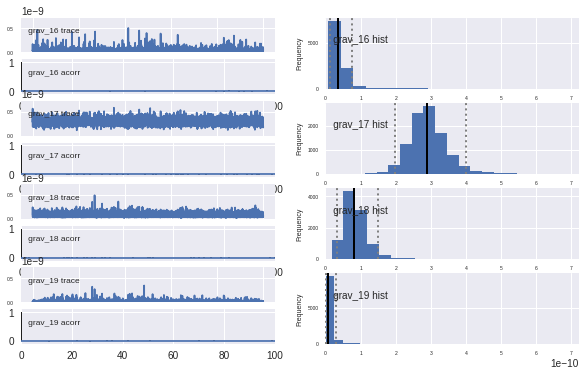

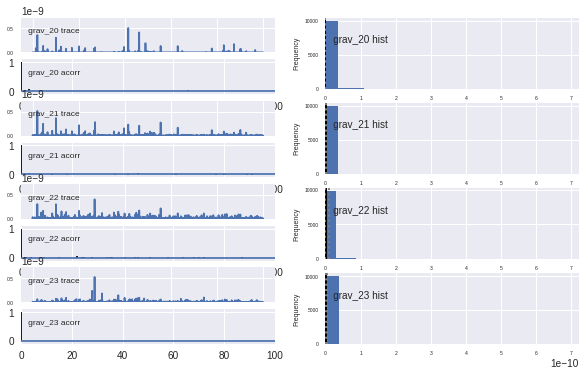

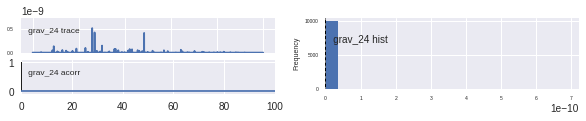

In [36]:
pymc.Matplot.plot(MCFS_RUN_32.trace('grav'))

In [37]:
MCFS_RUN_32.trace('grav').stats()

/home/miguel/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


{'95% HPD interval': array([[  2.41128359e-10,   2.66219621e-10,   2.64210043e-10,
           2.64395469e-10,   2.66746266e-10,   6.54675421e-11,
           2.15004651e-10,   2.76844585e-10,   3.07761580e-10,
           1.96797564e-10,   6.86011132e-12,   1.63930456e-10,
           3.77308708e-10,   3.55409560e-10,   5.78247115e-11,
           0.00000000e+00,   1.31700445e-11,   1.97195186e-10,
           3.25566082e-11,   1.24780951e-12,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00],
        [  3.01463944e-10,   2.71813274e-10,   2.75877562e-10,
           2.76909724e-10,   2.71260870e-10,   4.30915633e-10,
           3.88248849e-10,   4.88037015e-10,   5.45232253e-10,
           4.52212958e-10,   8.59399066e-11,   4.54601065e-10,
           6.07463510e-10,   5.86945475e-10,   4.19539252e-10,
           4.54843413e-12,   7.49238572e-11,   3.98917744e-10,
           1.48596854e-10,   3.06827849e-11,   0.00000000e+00,
       

###  Expected values plot

In [12]:
MCFS_RUN_8

NameError: name 'MCFS_RUN_8' is not defined

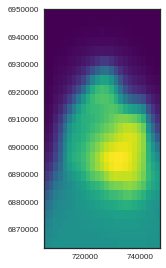

In [88]:
plt.imshow(MCFS_RUN.trace("grav", chain=-1)[8].reshape(25,25),
           cmap='viridis', origin='lower', extent=[7.050000e+05,747000,6863000,6950000])


In [86]:
MCFS_RUN.trace("grav", chain=-1)[0].sum(axis=1).reshape(25,25)

array([[  3.19552082e-10,   3.07991459e-10,   2.92444738e-10,
          2.87579093e-10,   2.84165329e-10,   2.81994144e-10,
          2.80917395e-10,   2.80449998e-10,   2.80204608e-10,
          2.80006593e-10,   2.79823936e-10,   2.79578611e-10,
          2.79219379e-10,   2.78892797e-10,   2.78618848e-10,
          2.78345920e-10,   2.78146705e-10,   2.78007418e-10,
          2.77847951e-10,   2.77680208e-10,   2.77615464e-10,
          2.77641539e-10,   2.77677996e-10,   2.77618973e-10,
          2.77462932e-10],
       [  3.48618204e-10,   3.32695833e-10,   3.10157260e-10,
          3.02647577e-10,   2.97253676e-10,   2.93417443e-10,
          2.90859408e-10,   2.89365574e-10,   2.88511098e-10,
          2.87870467e-10,   2.87239086e-10,   2.86682567e-10,
          2.86177215e-10,   2.85687192e-10,   2.85174714e-10,
          2.84714551e-10,   2.84216459e-10,   2.83825571e-10,
          2.83508315e-10,   2.83146926e-10,   2.82759727e-10,
          2.82465553e-10,   2.82365292e-10,

In [39]:
(interp_data.data.grid.grid[:, 2].max() - interp_data.data.grid.grid[:, 2].min()) *0.9

0.18718532170546623

In [40]:
interp_data.resolution

array([50, 50, 50])

In [63]:
tz_, b_ = precompute_grav(interp_data)

0.1908919617392378


In [56]:
%debug

> <ipython-input-52-0e9e43bb832d>(62)precompute_grav()
     60 
     61         # Selection of the x y z coordenates for each measurement and computed distance in those coordinates
---> 62         s_gr_x = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, :25].T[b].reshape(25,-1) - ab_g[:,0].reshape(25,-1)).astype('float')
     63         s_gr_y = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, 25:50].T[b].reshape(25,-1) - ab_g[:,1].reshape(25,-1)).astype('float')
     64         s_gr_z = (np.repeat(interp_data.data.grid.grid, 25, axis=1)[:, -25:].T[b].reshape(25,-1) - ab_g[:,2].reshape(25,-1)).astype('float')

ipdb> range
<class 'range'>
ipdb> range_
0.18718532170546623
ipdb> i_0
0
ipdb> i_1
25
ipdb> ab_g
array([[0.3372890540860558, 0.18611927452817562, 0.5528433277493487],
       [0.34800549097536115, 0.18611927452817562, 0.5528433277493487],
       [0.36943836475397174, 0.18611927452817562, 0.5528433277493487],
       [0.3908712385325824, 0.18611927452817562, 0.55284332774

7523.4

In [8]:
import pymc3 as pm

In [9]:
# with pm.Model():
#     Z = pm.Normal('Z_unc', interp_data.data.interfaces['Z'].as_matrix().astype('float'),
#                   interp_data.data.interfaces['Z_std'].as_matrix().astype('float'))

In [10]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph( interp_data.interpolator.tg.input_parameters_list(),
                              [interp_data.interpolator.tg.whole_block_model(0)], on_unused_input='ignore',
                            )

In [11]:
input_data_P = interp_data.get_input_data()

[3, 3]


In [12]:
# This is the creation of the model
import pymc3 as pm
theano.config.compute_test_value = 'off'
theano.config.warn_float64 = 'warn'
model = pm.Model()
with model:
    # Stochastic value
    Z_rest = pm.Normal('Z_unc_rest',
       interp_data.interpolator.pandas_rest_layer_points['Z'].as_matrix().astype('float32'),
       interp_data.interpolator.pandas_rest_layer_points['Z_std'].as_matrix().astype('float32'),
                  dtype='float32', shape = (66))
    
    Z_ref = pm.Normal('Z_unc_ref', interp_data.interpolator.ref_layer_points[:, 2].astype('float32'),
              interp_data.interpolator.ref_layer_points[:, 2].astype('float32'),
              dtype='float32', shape = (66))

    # We convert a python variable to theano.shared
    input_sh = []
    for i in input_data_P:
        input_sh.append(theano.shared(i))
        # We add the stochastic value to the correspondant array
    input_sh[4] = T.set_subtensor(
    input_sh[4][:, 2], Z_ref)

    input_sh[5] = T.set_subtensor(
    input_sh[5][:, 2], Z_rest)

    geo_model = pm.Deterministic('GeMpy', geomodel(input_sh[0], input_sh[1], input_sh[2],
                                                   input_sh[3], input_sh[4], input_sh[5]))

/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/pfunc.py:96: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  [clone_d[i] for i in owner.inputs], strict=rebuild_strict)
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/pfunc.py:96: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  [clone_d[i] for i in owner.inputs], strict=rebuild_strict)
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/pfunc.py:96: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  [clone_d[i] for i in owner.inputs], strict=rebuild_strict)
/home/miguel/anaconda3/lib/python3.6/site-packages/theano/compile/function_module.py:177: UserWarning: You are creating a TensorVaria

In [13]:
theano.config.compute_test_value = 'ignore'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    step = pm.NUTS()
    trace = pm.sample(30, tune=10, init=None, step=step, )

  0%|          | 0/40 [00:00<?, ?it/s]/home/miguel/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.2776672870559196e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
100%|██████████| 40/40 [00:25<00:00,  2.03it/s]/home/miguel/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:418: UserWarning: Chain 0 contains only 30 samples.
  % (self._chain_id, n))
/home/miguel/anaconda3/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [15]:
input_data_T = interp_data.interpolator.tg.input_parameters_list()






select = interp_data.interpolator.pandas_rest_layer_points['formation'] == 'Reservoir'

In [16]:
import theano
import theano.tensor as T
geomodel = theano.OpFromGraph(input_data_T, [interp_data.interpolator.tg.whole_block_model(0)], on_unused_input='ignore')

ValueError: Cannot compute test value: input 0 (Position of the dips) of Op Subtensor{int64:int64:, ::}(Position of the dips, ScalarFromTensor.0, ScalarFromTensor.0) missing default value.  
Backtrace when that variable is created:

  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5483455a72af>", line 1, in <module>
    interp_data = gp.InterpolatorInput(geo_data, compile_theano=False, u_grade=[3,3])
  File "../gempy/DataManagement.py", line 941, in __init__
    self.interpolator = self.set_interpolator(**kwargs)
  File "../gempy/DataManagement.py", line 1094, in set_interpolator
    interpolator = self.InterpolatorClass(geo_data_in, geo_data_in.grid, *args, **kwargs)
  File "../gempy/DataManagement.py", line 1185, in __init__
    self.tg = theanograf.TheanoGraph_pro(dtype=dtype, verbose=verbose,)
  File "../gempy/theanograf.py", line 94, in __init__
    self.dips_position_all = T.matrix("Position of the dips")


Because now the GeMpy model is a theano operation and not a theano function, to call it we need to use theano variables (with theano functions we call them with python variables). This is very easy to modify, we just need to use theano shared to convert our python input data into theano variables.

The pymc3 objects are already theano variables (pm.Normal and so on). Now the trick is that using the theano function T.set_subtensor, we can change one deterministic value of the input arrays(the ones printed in the cell above) by a stochastic pymc3 object. Then with the new arrays we just have to call the theano operation and pymc will do the rest

In [ ]:
# This is the creation of the model
import pymc3 as pm
theano.config.compute_test_value = 'off'
model = pm.Model()
with model:
    # Stochastic value
    reservoir = pm.Normal('reservoir', np.array([0], dtype='float64')
                          , sd=np.array([0.09], dtype='float64'), dtype='float64', shape=(1))
    
    # We convert a python variable to theano.shared
    ref = theano.shared(input_data_P[4])
    rest = theano.shared(input_data_P[5])
    
    # We add the stochastic value to the correspondant array
    ref = pm.Deterministic('reference', T.set_subtensor(
       ref[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2],
       ref[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2]+reservoir))
    rest = pm.Deterministic('rest', T.set_subtensor(
        rest[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2],
        rest[T.nonzero(T.cast(select.as_matrix(), "int8"))[0], 2]+reservoir))#
  
    geo_model = pm.Deterministic('GeMpy', geomodel(theano.shared(input_data_P[0]),
                                                  theano.shared(input_data_P[1]),
                                                  theano.shared(input_data_P[2]),
                                                  theano.shared(input_data_P[3]),
                                                  ref, rest))

In [ ]:
theano.config.compute_test_value = 'ignore'
# This is the sampling
# BEFORE RUN THIS FOR LONG CHECK IN THE MODULE THEANOGRAF THAT THE FLAG THEANO OPTIMIZER IS IN 'fast_run'!!
with model:
   # backend = pm.backends.ndarray.NDArray('geomodels')
    step = pm.NUTS()
    trace = pm.sample(30, init=None, step=step, )

In [ ]:
gp.trace.get_values('GeMpy')[0][-1,0,:])

In [ ]:
gp.plot_section(geo_data, trace.get_values('GeMpy')[0][-1, 0, :], 13,
                       direction='y', plot_data=False)

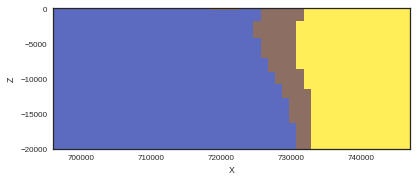

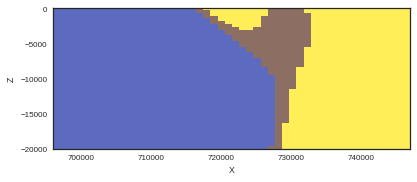

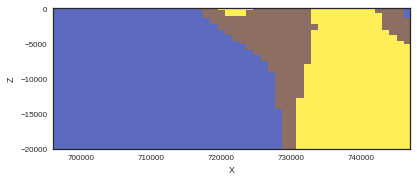

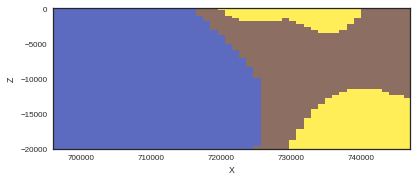

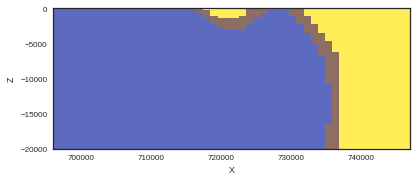

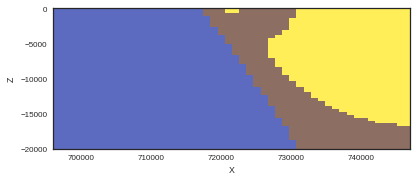

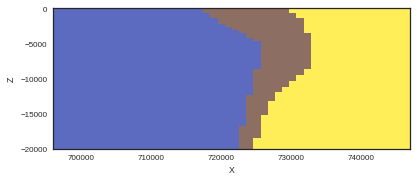

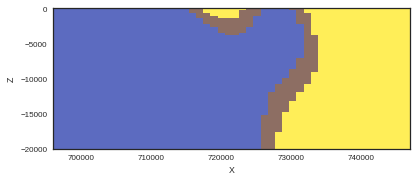

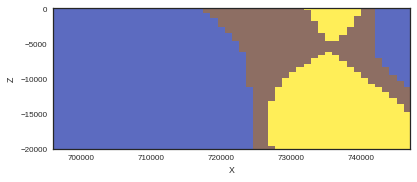

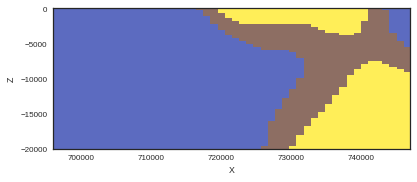

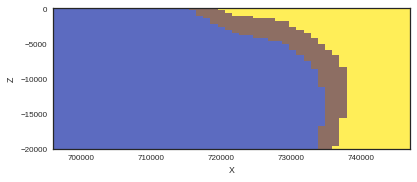

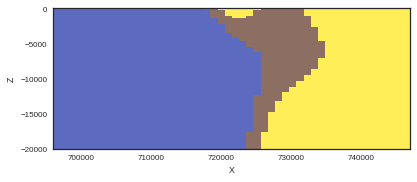

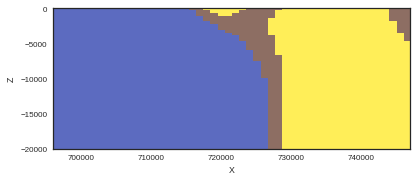

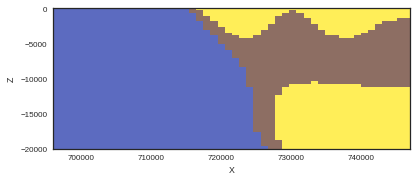

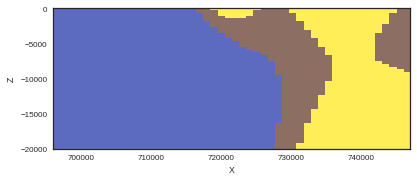

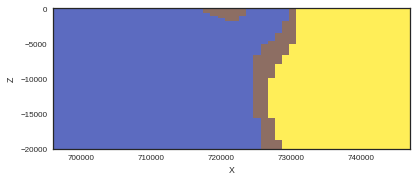

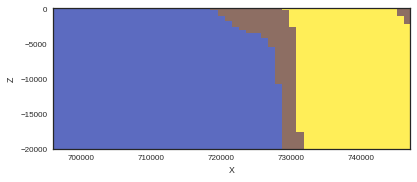

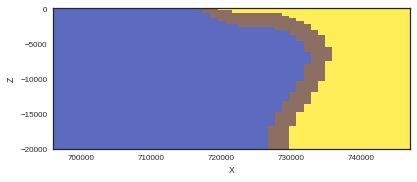

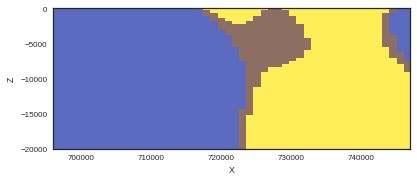

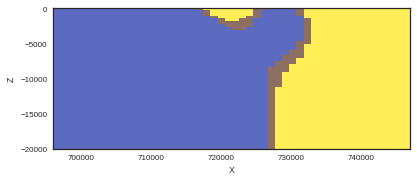

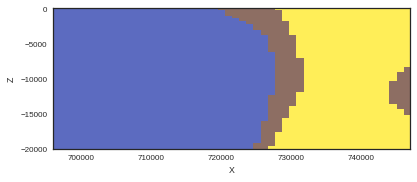

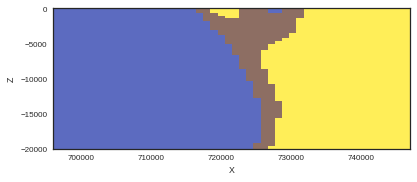

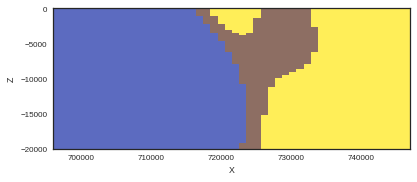

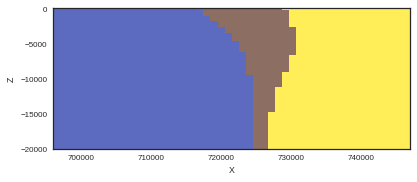

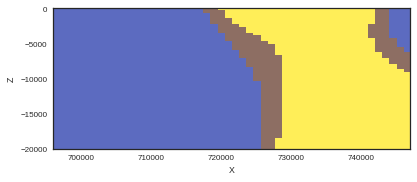

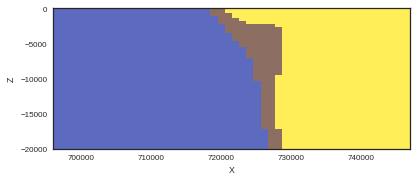

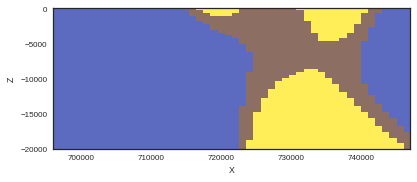

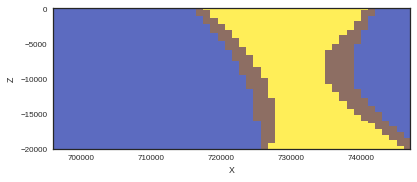

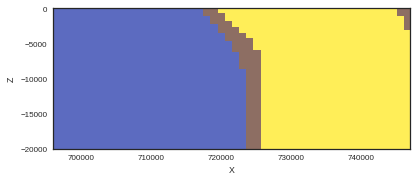

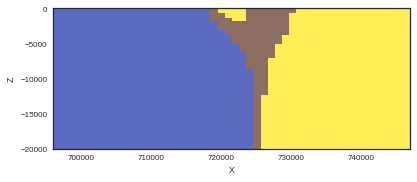

IndexError: index 30 is out of bounds for axis 0 with size 30

In [17]:
import matplotlib.pyplot as plt
for i in range(100):
    gp.plot_section(geo_data, trace.get_values('GeMpy')[i][-1, 0, :], 13,
                       direction='y', plot_data=False)
    plt.show()

In [18]:
interp_data.interpolator.tg.u_grade_T.get_value()

array([3, 3])